In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from collections import Counter
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from nltk import ngrams
from nltk.probability import FreqDist
from sklearn.manifold import TSNE
from wordcloud import WordCloud

# Carga de datos

Para el presente ejercicio se utilizarán las siguientes categorías de productos anotados de reviews de Amazon:
- Clothing
- Office products
- Video games

De este modo trabajaremos con reviews negativas y positivas de diferentes temas.

Los datos se han descargado de: http://jmcauley.ucsd.edu/data/amazon/ y se han almacenado en el directorio `datasets`.

In [2]:
datasets_path = '../datasets'

clothing_json = 'reviews_Clothing_Shoes_and_Jewelry_5.json.gz'
office_json = 'reviews_Office_Products_5.json.gz'
videogames = 'reviews_Video_Games_5.json.gz'

In [3]:
df_office = pd.read_json(os.path.join(datasets_path, office_json), lines=True, compression='gzip')
df_clothing = pd.read_json(os.path.join(datasets_path, clothing_json), lines=True, compression='gzip')
df_videogames = pd.read_json(os.path.join(datasets_path, videogames), lines=True, compression='gzip')

# Normalizamos el número de estrellas

En función del número de estrellas las reviews serán etiquetadas como:
- **Negativas** (0): 1 ó 2 estrellas
- **Positivas** (1): 3, 4 ó 5 estrellas

In [4]:
df_clothing.loc[:, 'sentiment'] = [1 if rank < 3 else 0 for rank in df_clothing['overall']]
df_office.loc[:, 'sentiment'] = [1 if rank < 3 else 0 for rank in df_office['overall']]
df_videogames.loc[:, 'sentiment'] = [1 if rank < 3 else 0 for rank in df_videogames['overall']]

# Contrucción del corpus de trabajo

De cara a poder replicar este ejercicio en cualquier máquina, se selecciona al azar un subconjunto reducido de reviews con el que trabajaremos en este y en el resto de notebooks.

Se extraerán 2500 reviews positivas y negativas para cada corpus.

In [5]:
n_reviews_per_sentiment = 2500

df_clothing = df_clothing.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_reviews_per_sentiment)))
df_office = df_office.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_reviews_per_sentiment)))
df_videogames = df_videogames.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), n_reviews_per_sentiment)))

In [6]:
df_clothing['category'] = 'clothing'
df_office['category'] = 'office'
df_videogames['category'] = 'videogames'

Combinamos los tres corpus en uno.

In [7]:
df_final = pd.concat([df_clothing, df_office, df_videogames])

Guardamos el corpus en `data` para poder cargarlo desde otros notebooks.

In [8]:
df_final.to_csv('../data/corpus.csv', index=False)

# Análisis exploratorio

## Cardinalidad del vocabulario

In [9]:
df_final.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment,category
75468,A36BI9SPO3LTC8,B0023ZQDEC,Gerbera Daisy,"[0, 0]",Not a good fit for me. Much too big. I didn't ...,3,Not good for me,1360972800,"02 16, 2013",0,clothing
277345,AL1WTXQJCKT8X,B00HWF7KPY,"Granny ""Joyous-soul""","[0, 0]",good fit- not to thin- love the less thicker ...,5,Surprised,1403308800,"06 21, 2014",0,clothing
111388,A2QOT4L1QFYYIW,B003VFGW76,lu shenglan,"[0, 0]",Quality is very goodMy husband liked itThe nex...,5,Quality is very good,1387152000,"12 16, 2013",0,clothing


In [10]:
splitted_reviews = df_final['reviewText'].str.lower().str.split()

De cara a una aproximación rápida, únicamente convertimos a minúsculas y tokenizamos por espacios. Se entiende que un procesado más fino devolvería valores más ajustados, pero no es el objetivo en este punto.

In [11]:
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

In [12]:
words[:10]

0     not
1       a
2    good
3     fit
4     for
5     me.
6    much
7     too
8    big.
9       i
dtype: object

In [13]:
vocabulary_ = Counter(words)

El vocabulario identificado está compuesto por 115217 tokens.

In [14]:
len(vocabulary_)

112877

Podemos comprobar como los tokens más comunes son, como cabía esperar, stopwords.

In [15]:
vocabulary_.most_common(15)

[('the', 110973),
 ('to', 56936),
 ('and', 56914),
 ('a', 54854),
 ('i', 51097),
 ('of', 36682),
 ('is', 35323),
 ('it', 34801),
 ('this', 26436),
 ('you', 25888),
 ('in', 23300),
 ('for', 23274),
 ('that', 22532),
 ('with', 16646),
 ('but', 16536)]

## Distribución de reviews por número de estrellas

Distribución de reviews por número de estrellas para todos los subconjuntos de datos de las distintas categorías y para el corpus final.

Del los subsets extraídos, podemos que la mayor parte de reviews se corresponde con aquellas con 5 y 2 estrellas.

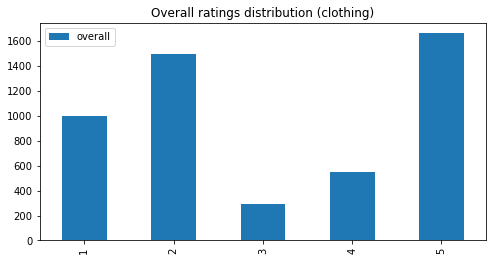

In [16]:
aux_clothing = pd.DataFrame(df_clothing['overall'].value_counts(sort=False).sort_index())
ax_clothing = aux_clothing.plot(kind='bar', title='Overall ratings distribution (clothing)', figsize=(8, 4))

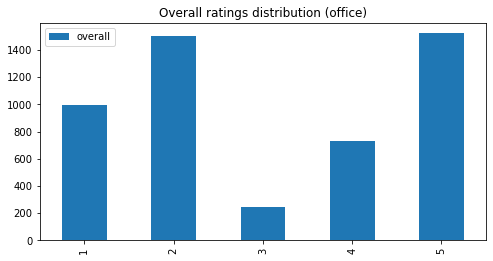

In [17]:
aux_office = pd.DataFrame(df_office['overall'].value_counts(sort=False).sort_index())
ax_office = aux_office.plot(kind='bar', title='Overall ratings distribution (office)', figsize=(8, 4))

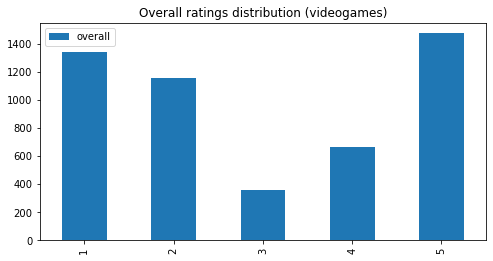

In [18]:
aux_videogames = pd.DataFrame(df_videogames['overall'].value_counts(sort=False).sort_index())
ax_videogames = aux_videogames.plot(kind='bar', title='Overall ratings distribution (videogames)', figsize=(8, 4))

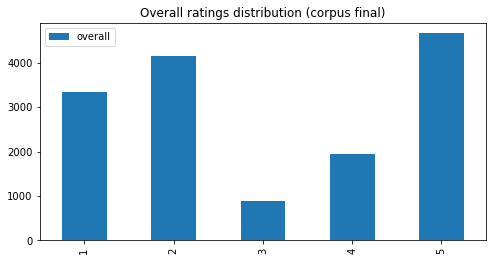

In [19]:
aux_final = pd.DataFrame(df_final['overall'].value_counts(sort=False).sort_index())
ax_final = aux_final.plot(kind='bar', title='Overall ratings distribution (corpus final)', figsize=(8, 4))

## Número de reviews positivas / negativas

Al haber seleccionado de manera estratificada las reviews (2500 por categoría) deberíamos tener 7500 reviews negativas y 7500 positivas (2500 reviews/categoría x 3 categorías). 

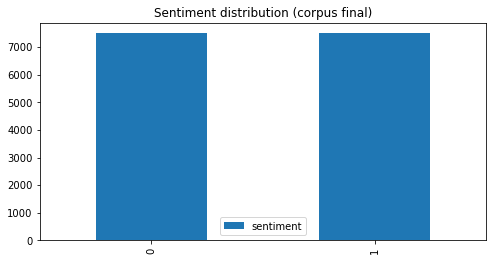

In [20]:
aux_final = pd.DataFrame(df_final['sentiment'].value_counts(sort=False).sort_index())
ax_final = aux_final.plot(kind='bar', title='Sentiment distribution (corpus final)', figsize=(8, 4))

## N-grams más frecuentes

Realizamos el cálculo de los 2-gramas y 3-grams directamente de la Series de pandas con todas las palabras. Al estar interesados únicamente en los más frecuentes no habrá problemas al combinar el último token de una review con el token inicial de la siguiente. Esto nos permite agilizar el cómputo en esta etapa previa de exploración.

In [21]:
words[:10]

0     not
1       a
2    good
3     fit
4     for
5     me.
6    much
7     too
8    big.
9       i
dtype: object

In [22]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [23]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

Parece evidente que la eliminación de stopwords es necesaria.

In [24]:
bigrams_freq_.most_common(10)

[(('of', 'the'), 9433),
 (('in', 'the'), 6248),
 (('on', 'the'), 5090),
 (('is', 'a'), 4508),
 (('it', 'is'), 4218),
 (('and', 'the'), 4205),
 (('if', 'you'), 4181),
 (('the', 'game'), 4098),
 (('to', 'the'), 4025),
 (('i', 'have'), 3936)]

In [25]:
trigrams_freq_.most_common(10)

[(('a', 'lot', 'of'), 1259),
 (('this', 'is', 'a'), 1038),
 (('this', 'game', 'is'), 945),
 (('one', 'of', 'the'), 828),
 (('you', 'have', 'to'), 808),
 (('the', 'game', 'is'), 647),
 (('if', 'you', 'are'), 613),
 (('i', 'had', 'to'), 562),
 (('it', 'is', 'a'), 554),
 (('some', 'of', 'the'), 511)]

## Nube de palabras

In [26]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

De un vistazo puede verse que varias de las palabras más frecuentes se corresponden con las categorías escogidas ('game', 'printer', 'paper', ...) y con el sentimiento ('good', 'easy', 'great', ...).

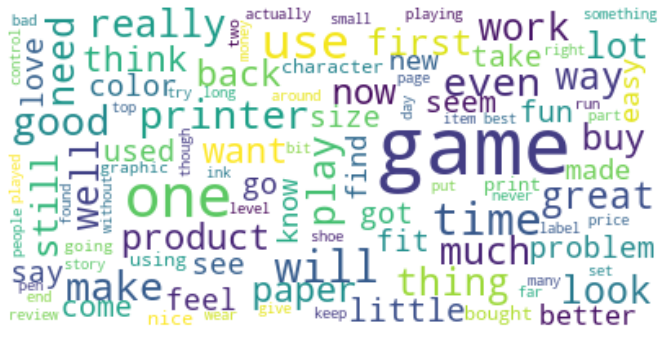

In [27]:
plot_word_cloud(words)

## 2D Word2Vec embeddings

### Entrenamiento del Word2Vec

Para reducir los tiempos de cómputo, realizamos el estudio sobre un conjunto reducido del corpus de trabajo.

In [28]:
corpus_ = df_final['reviewText'].sample(1000)
corpus_ = corpus_.str.split()

In [29]:
w2v_params = {
    'sg': 1,
    'size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

In [30]:
w2v_model = Word2Vec(**w2v_params)

In [31]:
w2v_model.build_vocab(corpus_)

In [32]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.vocab)))

Vocabulario compuesto por 2856 palabras


In [33]:
w2v_model.train(sentences=corpus_, total_examples=w2v_model.corpus_count, epochs=20)

(1659768, 2840800)

In [34]:
w2v_model.save('../models/w2v_sg_d300_mc5_w5.pkl')

### Visualización

In [35]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    plt.show()

In [36]:
keys = ['game', 'printer', 'jeans']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [37]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [38]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [39]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

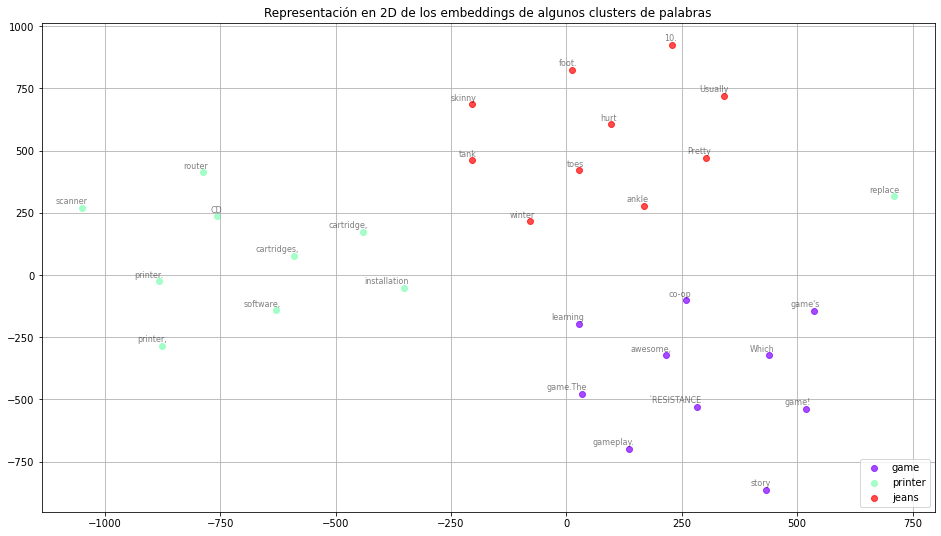

In [40]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

## Conclusiones

Un simple vistazo a los tokens más repetidos nos permite ver que:

- El total de reviews original es enorme por lo que se hace necesario obtener un subset de las mismas con el que realizar este ejercicio
- Es necesario eliminar las palabras más repetidas (stopwords) ya que apenas aportan valor
- Sin necesidad de procesar demasiado el corpus se ha demostrado que es posible detectar palabras cuya semántica está directamente relacionada con las categorías escogidas, así como con los sentimientos expresados
- Como posibles análisis a realizar además de lo presentado, se propone:
    - Validar que todas (o al menos la mayoría) de reviews están escritas en inglés
    - Estudiar la distribución de categorías gramaticales por número de estrellas
    - Estudiar la presencia de entidades nombradas